# TD 4 | Étude des vibrations des aubes d'un rouet de compresseur d'un turbofan

Florent FOREST

forest@lipn.univ-paris13.fr

---

Objectifs du TD :

* pratiquer sur un use case concret d'analyse statistique de données de production aéronautiques
* PCA
* tests statistiques et coefficients de corrélation

---

## Présentation du problème

On considère le **rouet de compresseur** de la **turbine à gaz d'un turbopropulseur** d'hélicoptère. Celui-ci est constitué de 13 **aubes**.

<img src="rc/turbo-helico.png" />

<img src="rc/compresseur.png" /> <img src="rc/compresseur-2.png" />

En production, après la fabrication et montage de la pièce, on mesure les vibrations des aubes grâce à une technique appelée **tip-timing**. Cette technique consiste à mesurer la position d'une aube en rotation par rapport à sa position au repos. En effet, les vibrations dues à la rotation entraînent un **décalage de la position des aubes** (voir schéma ci-dessous). 

<img src="rc/tiptiming.png"/>

La mesure de ce déplacement maximal à un régime (vitesse de rotation) donné permet de déduire le niveau vibratoire de chacune des aubes. Voici les résultats obtenus pour chacune des 13 aubes :

<img src="rc/vibrations.png" />

<div style="color: #bb1111; font-size: 16px; background-color: #ffeeee; padding: 20px; border-radius: 15px">
    <p><b>Problème :</b> on observe un niveau de vibrations anormal pour l'aube numérotée 11 dans le tableau ci-dessus (déplacement maximal de 0.99 mm). Cependant, il est impossible d'identifier de manière certaine cette aube, car l'aube n°1 n'est pas identifiée : il peut y avoir un décalage circulaire des mesures. On sait seulement qu'une aube vibre davantage que les autres. Comment peut-on identifier cette aube afin de la remplacer ?</p>
</div>

## Présentation des données

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p>On dispose de données de production sur les aubes de ce compresseur !</p>
</div>

Durant la production, de nombreuses caractéristiques géométriques de chaque aube sont mesurées. Ces données géométriques sont les suivantes :

* 17 variables géométriques concernant la forme (bord d'attaque BA, bord de fuite BF, etc.) de l'aube
* 94 variables d'épaisseurs mesurées à différents points de l'aube

soit un total de 111 variables mesurées par aube. Ces données se trouvent dans le fichier `Rouet_geometries.csv` (voir figures ci-dessous).

<img src="rc/geometries.png" />
<img src="rc/epaisseurs.png" />

Enfin, les données de vibrations issues du tip-timing se trouvent dans le fichier `Rouet_vibrations.csv`.

<img src="rc/vibrations.png" />

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p><b>Attention :</b> Les numérotations des aubes dans les données géométriques et les résultats du tip-timing ne sont pas les mêmes (permutation circulaire) !</p>
</div>

## 1. Chargement et préparation des données

### 1.1 Lecture des données

Charger les deux jeux de données, géométries (`./data/Rouet_geometries.csv`) et vibrations (`./data/Rouet_vibrations.csv`), dans des DataFrames pandas. Il sera nécessaire de prêter attention au format des fichier (header, séparateur de colonnes, typage des colonnes, etc.).

**Indice** : l'encodage des fichier CSV n'est pas UTF-8, il faudra donc préciser l'option `encoding='latin'` à la fonction `pandas.read_csv`.

In [ ]:
!git clone https://github.com/FlorentF9/SupGalilee-tdstats.git

In [ ]:
import os
os.chdir('SupGalilee-tdstats')

In [1]:
import pandas as pd
import numpy as np

In [2]:
geometries = pd.read_csv('./data/Rouet_geometries.csv',
                         skiprows=[0, 1, 16],
                         encoding='latin',
                         sep=';',
                         decimal=',')
print(geometries.shape)
geometries.head()

(13, 112)


,N° Pale,BA in,MI in,BF intra,BA ex,MI Ex,BF ex,BA in.1,MI in.1,BF intra.1,...,85,86,87,88,89,90,91,92,93,94
0,1,0.077,0.064,0.047,0.054,0.035,0.053,4.43,2.03,1.95,...,121,151,140,143,161,168,180,175,182,194
1,2,0.068,0.073,0.059,0.056,0.039,0.053,4.44,2.02,1.95,...,129,155,149,148,172,176,187,185,190,197
2,3,0.074,0.072,0.055,0.059,0.038,0.047,4.44,2.03,1.95,...,129,154,146,146,165,173,183,177,185,195
3,4,0.070,0.076,0.058,0.056,0.037,0.062,4.46,2.02,1.94,...,125,152,146,146,168,171,186,182,189,196
4,5,0.086,0.060,0.041,0.042,0.043,0.065,4.42,2.03,1.97,...,126,150,147,146,164,172,185,178,184,194


In [3]:
geometries.dtypes

N° Pale         int64
BA in         float64
MI in         float64
BF intra      float64
BA ex         float64
MI Ex         float64
BF ex         float64
BA in.1       float64
MI in.1       float64
BF intra.1    float64
BA ex.1       float64
MI Ex.1       float64
BF ex.1       float64
BF            float64
BA            float64
BF.1          float64
BA.1          float64
BF.2          float64
1               int64
2               int64
3               int64
4               int64
5               int64
6               int64
7               int64
8               int64
9               int64
10              int64
11              int64
12              int64
               ...   
65              int64
66              int64
67              int64
68              int64
69              int64
70              int64
71              int64
72              int64
73              int64
74              int64
75              int64
76              int64
77              int64
78              int64
79        

In [4]:
vibrations = pd.read_csv('./data/Rouet_vibrations.csv',
                         skiprows=1,
                         encoding='latin',
                         sep=';',
                         decimal=',')
vibrations

,N° Pale,Niveau vibratoire 1FPP (mm),Vitesse de rotation - Régime (RPM)
0,1,0.54,16532.3
1,2,0.60,16538.4
2,3,0.61,16543.6
3,4,0.53,16560.2
4,5,0.43,16550.8
5,6,0.65,16605.0
6,7,0.38,16662.8
7,8,0.43,16615.3
8,9,0.52,16635.0
9,10,0.46,16639.5


In [5]:
vibrations.dtypes

N° Pale                                 int64
Niveau vibratoire 1FPP (mm)           float64
Vitesse de rotation - Régime (RPM)    float64
dtype: object

### 1.2 Standardisez les variables géométriques afin d'obtenir des variables centrées (moyenne 0) et réduites (variance 1).

In [6]:
# geometries.drop('N° pale', axis=1) ...
# geometries[geometries.columns[1:]] ...
geometries.iloc[:, 1:] -= geometries.iloc[:, 1:].mean(axis=0)
geometries.iloc[:, 1:] /= geometries.iloc[:, 1:].std(axis=0)

In [7]:
print(np.isclose(geometries.iloc[:, 1:].mean(axis=0), 0).all(), np.isclose(geometries.iloc[:, 1:].std(axis=0), 1).all())

True True


In [8]:
geometries.head()

,N° Pale,BA in,MI in,BF intra,BA ex,MI Ex,BF ex,BA in.1,MI in.1,BF intra.1,...,85,86,87,88,89,90,91,92,93,94
0,1,-0.161086,-0.484324,-0.710906,0.610696,-1.519821,-0.406104,-0.202999,0.801337,-0.171184,...,-0.836621,-0.647103,-0.913944,-0.697765,-0.813632,-0.924694,-0.860578,-0.712645,-0.647033,-0.537099
1,2,-1.417553,1.089730,1.342822,1.028541,-0.713386,-0.406104,0.324799,-0.500835,-0.171184,...,-0.172433,-0.346663,-0.288614,-0.346178,-0.062991,-0.345368,-0.338494,0.040557,-0.012208,-0.301741
2,3,-0.579908,0.914835,0.658246,1.655308,-0.914994,-1.080064,0.324799,0.801337,-0.171184,...,-0.172433,-0.421773,-0.497057,-0.486813,-0.540672,-0.562615,-0.636828,-0.562005,-0.408974,-0.458646
3,4,-1.138338,1.614415,1.171678,1.028541,-1.116603,0.604836,1.380397,-0.500835,-1.283881,...,-0.504527,-0.571993,-0.497057,-0.486813,-0.335951,-0.707447,-0.413077,-0.185404,-0.091561,-0.380194
4,5,1.095382,-1.183904,-1.737770,-1.896373,0.093050,0.941816,-0.730798,0.801337,2.054210,...,-0.421504,-0.722214,-0.427576,-0.486813,-0.608912,-0.635031,-0.487661,-0.486685,-0.488327,-0.537099


## 2. Analyse exploratoire des données

### 2.1 Affichez le niveau vibratoire de chaque aube sur un bar plot

In [9]:
import matplotlib.pyplot as plt

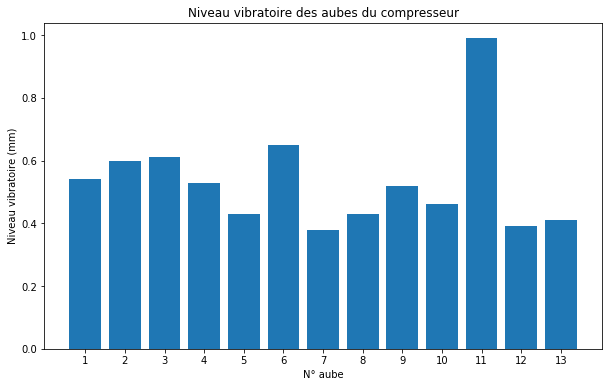

In [10]:
plt.figure(figsize=(10,6))
plt.bar(vibrations['N° Pale'], vibrations['Niveau vibratoire 1FPP (mm)'], tick_label=vibrations['N° Pale'])
plt.xlabel('N° aube')
plt.ylabel('Niveau vibratoire (mm)')
plt.title('Niveau vibratoire des aubes du compresseur');

### 2.2 Analyse par ACP de l'importance des variables géométriques

On dispose d'un grand nombre de variables géométriques (111 variables). On souhaite déterminer quelles sont les variables géométriques importantes en analysant leurs poids dans les composantes principales du jeu de données.

#### 2.2.1 Effectuez une ACP sur le jeu de données géométriques, puis calculez et visualisez la part de variance expliquée par chaque composante principale. Interprétez le résultat. Quelle part de variance est expliquée par les 2 premières CP ?

In [11]:
from sklearn.decomposition import PCA

In [12]:
geometries.shape

(13, 112)

Part de variance expliquée par CP :
[0.79257751 0.04885664 0.04451665 0.0385202  0.02116081 0.01338836
 0.01250898 0.00823894 0.00741161 0.00596559]
Pourcentage de variance totale expliquée :
99.3145298672893 %


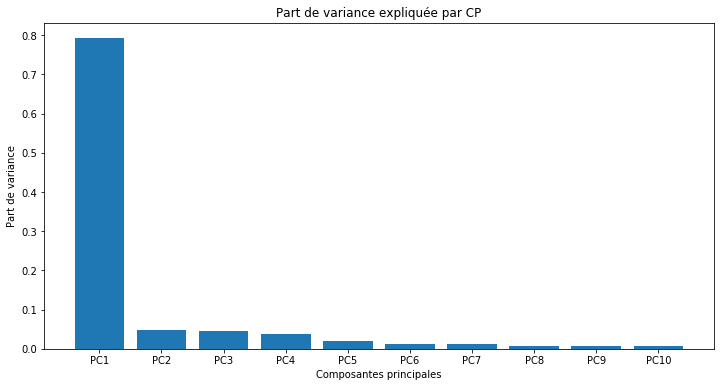

In [13]:
pca = PCA(n_components=10).fit(geometries.drop('N° Pale', axis=1))

print('Part de variance expliquée par CP :')
print(pca.explained_variance_ratio_)
print('Pourcentage de variance totale expliquée :')
print(pca.explained_variance_ratio_.sum()*100, '%')
plt.figure(figsize=(12,6))
plt.bar(np.arange(pca.n_components), pca.explained_variance_ratio_, tick_label=['PC'+str(i+1) for i in range(pca.n_components)], log=False)
plt.title('Part de variance expliquée par CP');
plt.ylabel('Part de variance')
plt.xlabel('Composantes principales');

In [14]:
pca.explained_variance_ratio_[:2].sum()

0.8414341461182345

Une technique très courante pour analyser l'importance des variables est de visualiser leurs poids dans le plan des 2 premières composantes principales.

#### 2.2.2 Visualisez le poids des variables géométriques dans le plan (PC1, PC2)

**Indice 1 :** utilisez pour cela les composantes des vecteurs principaux de la matrice `pca.components_`.

**Indice 2 :** Afin d'obtenir une graphique avec une bonne échelle entre -1 et 1, il est nécessaire d'appliquer aux poids de chaque composante principale un facteur d'échelle égal à $\sqrt{\text{variance expliquée}}$.

Voici le type de graphique, appelé _PCA factor loadings plot_ en anglais, que vous devriez obtenir :

<img src="rc/pca-plot.png" height=500px width=500px />

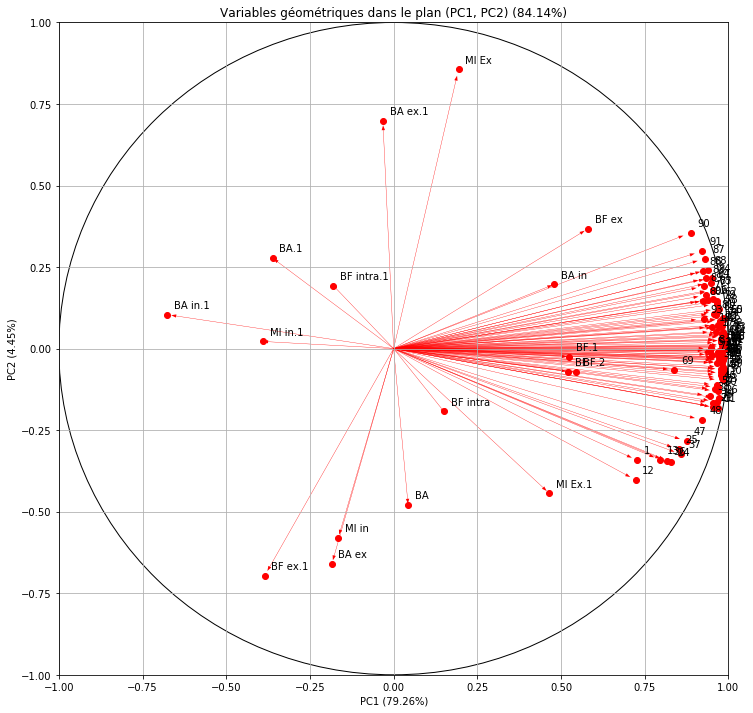

In [15]:
plt.figure(figsize=(12,12))

pc1 = pca.components_[0]
pc2 = pca.components_[1]

scalex = np.sqrt(pca.explained_variance_[0])
scaley = np.sqrt(pca.explained_variance_[1])

for i,variable in enumerate(geometries.columns[1:]):
    plt.scatter(pc1[i] * scalex, pc2[i] * scaley, color='r')
    plt.text(pc1[i] * scalex + 0.02, pc2[i] * scaley + 0.02, variable)
    plt.arrow(0, 0, pc1[i] * scalex * 0.96, pc2[i] * scaley * 0.96, color='r', linewidth=0.0005, head_width=0.01)
    
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[2]*100))
plt.title('Variables géométriques dans le plan (PC1, PC2) ({:.2f}%)'.format(pca.explained_variance_ratio_[:2].sum()*100))
plt.grid()

circle = plt.Circle((0, 0), 1.0, color='k', fill=False)
plt.gca().add_artist(circle);

#### 2.2.3 Interprétez le graphique précédent. Quelles sont les variables géométriques les plus importantes ?

Les variables d'épaisseurs (numérotées de 1 à 94) sont toutes situées dans la partie la plus à droite du plan des composantes principales. Elles ont donc un poids très important sur la PC1, beaucoup plus que les autres variables géométriques. Étant donné que la PC1 représente presque 80% de la variance, on peut en conclure que les variables d'épaisseurs sont les plus importantes.

## 3. Identification de l'aube anormale par analyse des corrélations

Suite aux analyses précédentes, on décide de se focaliser sur les variables géométriques correspondant aux épaisseurs de l'aube (variables 1-94). Par ailleurs, les experts mécaniciens nous ont informés que les vibrations étaient corrélées à l'épaisseur de l'aube en différentes points. Par conséquent, nous pouvons décrire les données géométriques en utilisant **seulement la première composante principale** : on se ramène donc à un cas **univarié**, avec une seule variable $\text{PC1}$ (projection sur la première composante principale).

**Objectif :** trouver la permutation circulaire des numérotations d'aubes qui **maximise** la corrélation entre vibrations et épaisseurs des aubes, afin d'identifier l'aube défectueuse.

Voici 3 coefficients de corrélation usuels permettant de mesurer l'association de deux variables (ici, $X =\text{PC1} $ et $Y = \text{vibration}$) :

Coefficient de corrélation | formule | lien wikipédia
---------------------------|----------|---------------
Corrélation de Pearson     | $\rho(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}$ | https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)
Corrélation de Spearman    | $\rho_S(X, Y) = \frac{\text{Cov}(\text{rank}(X), \text{rank}(Y))}{\sigma_{\text{rank}_X} \sigma_{\text{rank}(Y)}}$ | https://fr.wikipedia.org/wiki/Corr%C3%A9lation_de_Spearman
Corrélation de Kendall     | $\tau(X, Y) = \frac{2\sum_{i<j}\text{sign}(x_j-x_i)\text{sign}(y_j-y_i)}{N(N-1)}$ | https://fr.wikipedia.org/wiki/Tau_de_Kendall


### 3.1 Quel(s) coefficient(s) vous semble(nt) adapté(s) pour analyser les corrélations entre nos variables ?

Le coefficient de Pearson détecte les corrélations _linéaires_, or la relation entre géométrie et vibrations est probablement fortement non-linéaire. Il faut donc sélectionner un coefficient basé sur les **rangs**, i.e. Spearman ou Kendall.

Ensuite, on peut imaginer que les variables sont assez éloignées d'une loi normale (ce sont plutôt des distributions de valeurs extrêmes), donc Spearman ne sera pas très précis. Le meilleur choix est donc le coefficient de corrélation $\tau$ de Kendall.

### 3.2 Calculez les corrélations pour les 12 décalages circulaires possibles entre les données géométriques et les vibrations. Visualisez-les sur un graphique.

**Indice :** on peut facilement obtenir une permuation circulaire d'un jeu de données à l'aide de la fonction `numpy.roll(...)`.

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p><b>Rappel :</b> On n'utilise que la PC1 des variables géométriques !</p>
</div>

Il est recommandé de calculer les _$p$-values_ associées au coefficient de corrélation choisi. Ces valeurs permettent de déterminer si les corrélations trouvées sont **significatives ou non**. La $p$-value est associée aux deux hypothèses statistiques suivantes :

* $\mathcal{H}_0$ : les variables X et Y sont indépendantes (pas de corrélation)
* $\mathcal{H}_1$ : les variables X et Y sont dépendantes (corrélation)

La $p$-value correspond à la **probabilité de se tromper en rejetant l'hypothèse null $\mathcal{H}_0$**. On fait généralement le choix de rejeter l'hypothèse nulle lorsque $p$-value < 0.05, i.e. moins de 5% de chances de se tromper.

In [16]:
X = PCA(n_components=1).fit_transform(geometries.drop('N° Pale', axis=1)).squeeze(1)
X.shape

(13,)

In [17]:
X

array([ -2.62615061,   0.83281992,  -1.15115344,  -2.78452265,
        -0.74830039, -13.61527624, -10.47091609,  -0.9342382 ,
         0.51104608,  16.57887924,  -9.22697186,   4.63976181,
        18.99502244])

In [18]:
Y = vibrations['Niveau vibratoire 1FPP (mm)'].values
Y.shape

(13,)

In [19]:
Y

array([0.54, 0.6 , 0.61, 0.53, 0.43, 0.65, 0.38, 0.43, 0.52, 0.46, 0.99,
       0.39, 0.41])

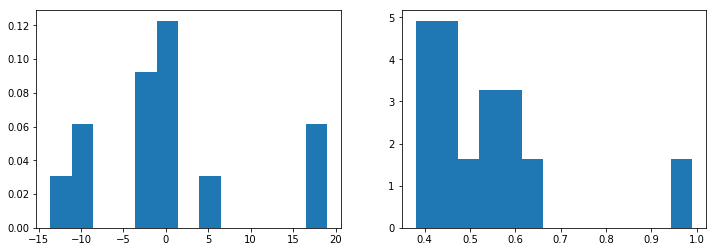

In [20]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(X, bins=13, density=True)
ax[1].hist(Y, bins=13, density=True);

In [21]:
import math
def kendall_tau(x, y):
    """Compute Kendall's tau correlation
    
    Arguments
        xs : float array (n)
            input variable 1
        ys : float array (n)
        input variable 2
        
    Returns
        tau : float in [-1, 1]
            correlation coefficient
        pvalue : float
            p-value
    """
    assert x.size == y.size
    size = x.size
    
    tot = (size * (size-1)) // 2
    s = np.array([np.sign(x[j] - x[i]) * np.sign(y[j] - y[i]) for j in range(size) for i in range(j)])
    tau = np.sum(s) / tot
    
    dis = np.sum(s < 0)  # number of discordant pairs
    # Exact p-value, see Maurice G. Kendall, "Rank Correlation Methods" (4th Edition), Charles Griffin & Co., 1970.
    c = min(dis, tot-dis)
    if size <= 0:
        raise ValueError
    elif c < 0 or 2*c > size*(size-1):
        raise ValueError
    elif size == 1:
        pvalue = 1.0
    elif size == 2:
        pvalue = 1.0
    elif c == 0:
        pvalue = 2.0/math.factorial(size) if size < 171 else 0.0
    elif c == 1:
        pvalue = 2.0/math.factorial(size-1) if (size-1) < 171 else 0.0
    else:
        new = [0.0]*(c+1)
        new[0] = 1.0
        new[1] = 1.0
        for j in range(3,size+1):
            old = new[:]
            for k in range(1,min(j,c+1)):
                new[k] += new[k-1]
            for k in range(j,c+1):
                new[k] += new[k-1] - old[k-j]
        pvalue = 2.0*sum(new)/math.factorial(size) if size < 171 else 0.0
        
    return tau, pvalue

In [22]:
shifts = np.arange(X.size)
correlations = np.zeros(shifts.size) 
pvalues = np.zeros(shifts.size)
for shift in shifts:
    correlations[shift], pvalues[shift] = kendall_tau(np.roll(X, shift), Y)

In [23]:
correlations, pvalues

(array([-0.32051282,  0.44871795,  0.08974359,  0.03846154,  0.03846154,
        -0.16666667,  0.44871795,  0.06410256, -0.34615385,  0.16666667,
        -0.26923077,  0.06410256, -0.08974359]),
 array([0.16348724, 0.03048244, 0.6754334 , 0.85773375, 0.85773375,
        0.50977457, 0.03048244, 0.76502485, 0.12885137, 0.43538045,
        0.25185761, 0.76502485, 0.76502485]))

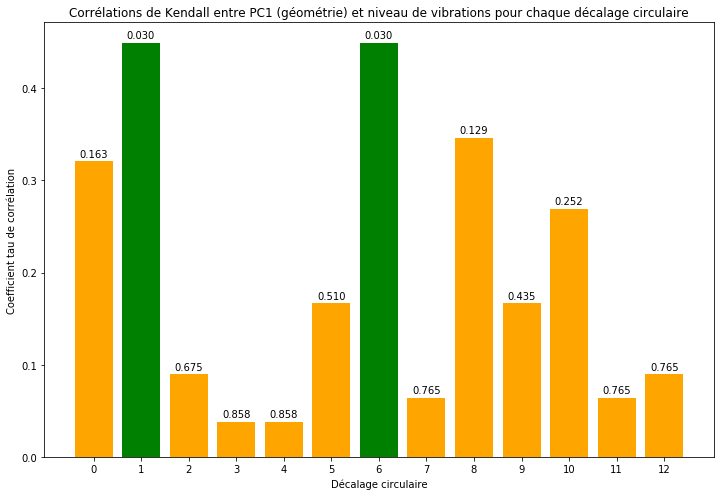

In [24]:
plt.figure(figsize=(12,8))
colors = ['g' if p < 0.05 else 'orange' for p in pvalues]
plt.bar(shifts, np.abs(correlations), tick_label=shifts, color=colors)
for shift, p in enumerate(pvalues):
    plt.text(shift - 0.3, np.abs(correlations)[shift] + 0.005, '{:.3f}'.format(p))
plt.title('Corrélations de Kendall entre PC1 (géométrie) et niveau de vibrations pour chaque décalage circulaire')
plt.xlabel('Décalage circulaire')
plt.ylabel('Coefficient tau de corrélation');

### 3.3 Quel est le décalage circulaire qui maximise la corrélation ? (il peut éventuellement en y avoir plusieurs) Peut-on en déduire l'aube anormale ?

Les décalages circulaires qui maximisent la corrélation de Kendall sont les décalages 1 et 6.

N° réel (géométries) | N° tip-timing (1) | N° tip-timing (6)
--|--|--
1 |13|8
2 |1 |9
3 |2 |10
4 |3 |11
5 |4 |12
6 |5 |13
7 |6 |1
8 |7 |2
9 |8 |3
10|9 |4
**11 (anormale)** |**10**|**5**
12|11|6
13|12|7

### 3.4 L'analyse de la PC1 ne s'est pas révélée suffisante, une analyse plus fine est nécessaire. Calculez, pour chaque décalage circulaire de la numérotation des aubes, les corrélations entre toutes les variables d'épaisseur (94 variables) et le niveau vibratoire. Concluez sur l'identité de l'aube défaillante, ainsi que sur la zone précise du défaut.

In [25]:
epaisseurs = geometries[[str(i) for i in range(1, 95)]]
epaisseurs.head()

,1,2,3,4,5,6,7,8,9,10,...,85,86,87,88,89,90,91,92,93,94
0,0.604613,-0.036400,-0.212269,0.006639,-0.013383,-0.803522,-0.989160,-0.130599,-0.327212,-0.223174,...,-0.836621,-0.647103,-0.913944,-0.697765,-0.813632,-0.924694,-0.860578,-0.712645,-0.647033,-0.537099
1,-0.566021,0.752275,0.339630,0.006639,0.160601,0.083384,0.089924,0.039180,0.020033,0.294909,...,-0.172433,-0.346663,-0.288614,-0.346178,-0.062991,-0.345368,-0.338494,0.040557,-0.012208,-0.301741
2,0.604613,0.121335,0.118871,-0.165978,0.247594,0.181930,0.000000,0.378737,-0.066778,0.087676,...,-0.172433,-0.421773,-0.497057,-0.486813,-0.540672,-0.562615,-0.636828,-0.562005,-0.408974,-0.458646
3,0.270146,-0.194136,-0.322649,0.006639,-0.361353,-0.507887,0.000000,-0.300378,0.106845,-0.430408,...,-0.504527,-0.571993,-0.497057,-0.486813,-0.335951,-0.707447,-0.413077,-0.185404,-0.091561,-0.380194
4,0.604613,-0.036400,0.008491,-0.079669,-0.709322,-0.113706,-0.719389,-0.639935,0.106845,0.191292,...,-0.421504,-0.722214,-0.427576,-0.486813,-0.608912,-0.635031,-0.487661,-0.486685,-0.488327,-0.537099


In [26]:
shifts = np.arange(X.size)
variables = np.arange(94)
correlations = np.zeros((shifts.size, variables.size)) 
pvalues = np.zeros((shifts.size, variables.size))
for shift in shifts:
    for v in variables:
        correlations[shift, v], pvalues[shift, v] = kendall_tau(np.roll(epaisseurs[str(v+1)], shift), Y)

In [27]:
correlations.max()

0.7051282051282052

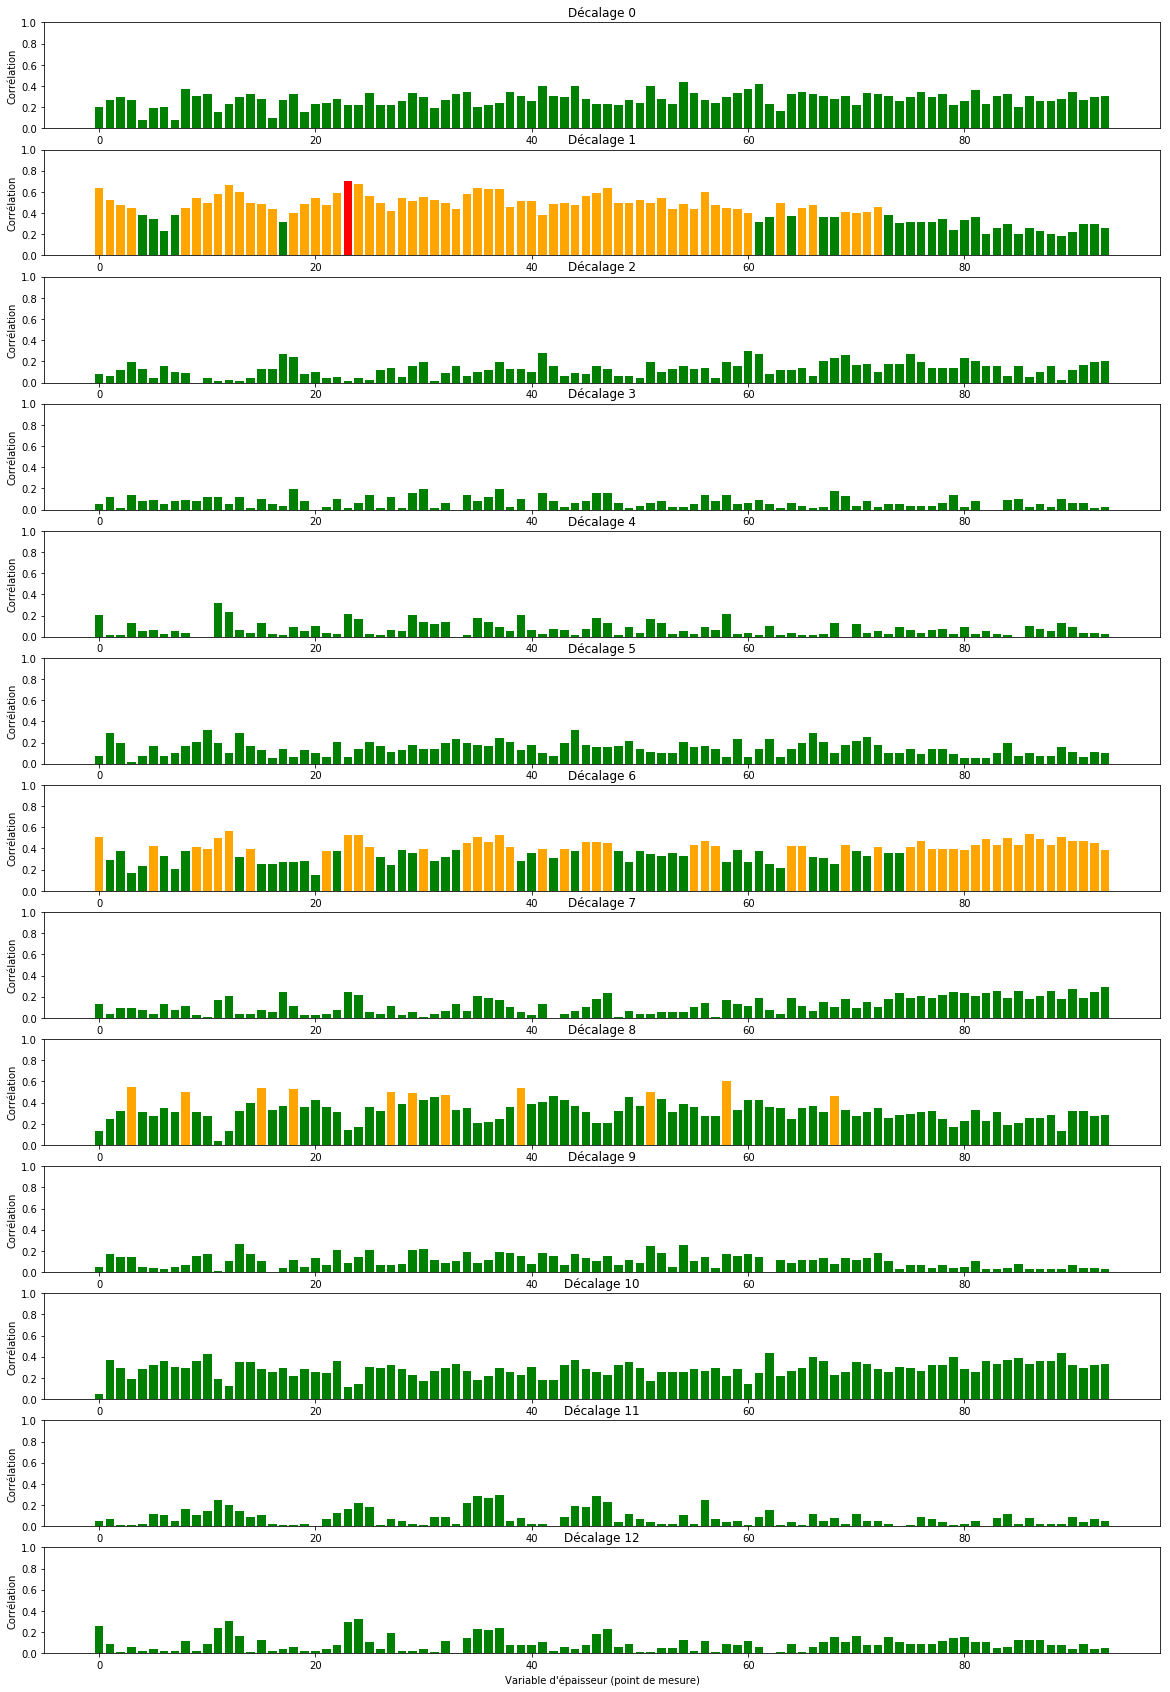

In [28]:
_, ax = plt.subplots(shifts.size, 1, figsize=(20, 30))
for s in range(shifts.size):
    tau = np.abs(correlations[s])
    colors = ['r' if tau[i] > 0.7 and p < 0.05 else 'orange' if p < 0.05 else 'g' for i,p in enumerate(pvalues[s])]
    ax[s].bar(variables, tau, color=colors)
    ax[s].set_ylim([0.0, 1.0])
    ax[s].set_xlabel('Variable d\'épaisseur (point de mesure)')
    ax[s].set_ylabel('Corrélation')
    ax[s].set_title('Décalage {}'.format(s));

---

**Conclusion :** la plus forte corrélation est obtenue avec un décalage circulaire de 1, pour la variable d'épaisseur 24 ($\tau = 0.705$). L'aube défectueuse est donc **l'aube n°10**, et la zone précise responsable du défaut de la pièce se situe **autour du point de mesure 24**.   